vae　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch211122/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch211122/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
!pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータの生成

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(x_train.shape)

torch.Size([1797, 64])


サンプルデータの図化

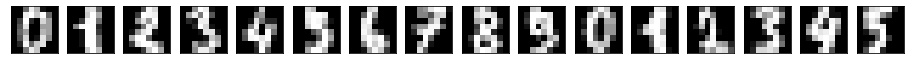

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
import torch.distributions as td

"""
def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * torch.sum( g )
  return -y
"""

class VAE(torch.nn.Module):
  
  class Net(torch.nn.Module):
    def __init__( self, n_in, n_mid, n_out, n_z ):
      super().__init__()
      print("create net class")
      self.fc1 = nn.Linear(n_in, n_mid)
      self.bn1 = nn.BatchNorm1d(n_mid)
      self.fc2_mean = nn.Linear(n_mid, n_z)
      self.fc2_var  = nn.Linear(n_mid, n_z)
      self.fc3 = nn.Linear(n_z  ,n_mid)
      self.fc4 = nn.Linear(n_mid,n_out)
      #self.drop1 = nn.Dropout(p=0.2)
    
      nn.init.constant_(self.fc1.bias,0)
      nn.init.constant_(self.fc2_mean.bias,0)
      nn.init.constant_(self.fc2_var.bias,0)
      nn.init.constant_(self.fc3.bias,0)
      nn.init.constant_(self.fc4.bias,0)
    
    def forward( self, x ):
      # encoder
      self.x1 = F.relu( self.fc1(x) )
      self.x2 = self.bn1( self.x1 )
      m1 = self.fc2_mean( self.x2 )
      v1 = self.fc2_var( self.x2 )
      self.mean = m1;
      self.log_var = v1;

      # reparametrization
      self.std = torch.exp( 0.5 * self.log_var )
      q_z = td.normal.Normal( self.mean, self.std )
      self.z = q_z.rsample()

      # decoder
      y = F.relu( self.fc3( self.z ) )
      #y = self.drop1( y )
      y = torch.sigmoid( self.fc4( y ) )
      self.out = y 

      return y, q_z
  
  class Loss(torch.nn.Module):
    def __init__(self):
      super().__init__()
      print("create loss class")

    def forward( self, y, x, q_z ):
      e1 = F.binary_cross_entropy( y , x, reduction="sum" )
      p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
      e2  = td.kl_divergence( q_z, p_z ).sum()
      #e2 = kl_divergence( mean, log_var )

      self.loss1 = e1
      self.loss2 = e2
      #print("e1,e2",e1,e2)
      return (e1+e2)

  def __init__( self, n_in, n_mid, n_out, n_z ):
    super( VAE, self ).__init__()
    print("create vae class")
    self.net  = self.Net( n_in, n_mid, n_out, n_z )
    self.loss = self.Loss()

  def forward( self, x ):
    y, q_z = self.net(x)
    output = self.loss( y, x, q_z )
    return output

プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'vae'
folder = './vae'
json_path = folder + '/' + project +'.json'

計算グラフをJSONファイルに変換する

In [10]:
def generate_json( json_path, input ):

    model = VAE( n_in, n_mid, n_out, n_z )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [11]:
torch.manual_seed( 1 )

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#x.requires_grad = True

model = generate_json( json_path, x )

create vae class
create net class
create loss class
[SAVE] ./vae/vae.json
skip: VAE/Net[net]/Linear[fc1]/weight/fc1
skip: VAE/Net[net]/Linear[fc1]/weight/fc1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/Linear[fc2_mean]/weight/fc2_mean
skip: VAE/Net[net]/Linear[fc2_mean]/weight/fc2_mean
skip: VAE/Net[net]/Linear[fc2_var]/weight/fc2_var
skip: VAE/Net[net]/Linear[fc2_var]/weight/fc2_var
skip: VAE/Net[net]/Linear[fc3]/weight/fc3
skip: VAE/Net[net]/Linear[fc3]/weight/fc3
skip: VAE/Net[net]/Linear[fc4]/weight/fc4
skip: VAE/Net[net]/Linear[fc4]/weight/fc4


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.4703369140625 (up to 1e-05 allowed)
Relative difference: 0.0003294008981624594 (up to 1e-05 allowed)
  _module_class,


一回の順伝播、逆伝播のC++コードを生成する

In [12]:
CV.convert_cpp_code( project, folder, model, x, json_path )

[JSON] ./vae/vae.json
{'name': 'VAE/Net[net]/Linear[fc1]/weight/weight.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'VAE/Net[net]/Linear[fc1]/bias/bias.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/weight/weight.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 5}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/bias/bias.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 6}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/running_mean/running_mean', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 7}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/running_var/running_var', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 8}
{'name': 'VAE/Net[net]/Linear[fc2_mean]/weight/weight.17', 'op': 'prim::GetAttr', 

In [13]:
# check code
print(x.shape)
with torch.set_grad_enabled(True):
  model.train()
  output = model( x )
  print("output",output)
  output.backward()
  print("input_grad",x.grad)

torch.Size([32, 64])
output tensor(1448.0217, grad_fn=<AddBackward0>)
input_grad None


C++コードをコンパイル、リンクする

In [14]:
#!g++ -std=c++14 ./vae/vae.cpp ./vae/vae_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./vae/vae
C_SRC = './vae/vae.cpp ./vae/vae_param.cpp'
C_LIB = '../../../xtensor'
C_EXE = './vae/vae'
!echo "SRC = "$C_SRC
!echo "LIB = "$C_LIB
!echo "EXE = "$C_EXE
!g++ -std=c++14 $C_SRC -D_NOTEBOOK -I $C_LIB -lcblas -o $C_EXE

SRC = ./vae/vae.cpp ./vae/vae_param.cpp
LIB = ../../../xtensor
EXE = ./vae/vae


(注) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [15]:
!./vae/vae

### forward computation ...
{ 1452.403442}
### backward computation ...
input_grad{{-0.125258,  0.182919, -0.01408 , ..., -0.088459, -0.858717,  0.31935 },
 { 0.159821,  0.692014,  0.556623, ..., -0.145081,  0.285678,  0.64644 },
 { 1.913896, -1.648967,  0.047376, ...,  0.648749, -0.584697, -1.671622},
 ..., 
 {-0.253909, -0.497299,  0.239077, ..., -0.459145, -0.707026, -0.537639},
 { 0.39497 , -0.093664, -0.296295, ..., -0.112299, -0.966484,  0.441378},
 { 0.594774, -0.168871, -0.430799, ..., -0.309275,  0.039534, -0.03901 }}


ミニバッチによる学習の実行(python)

In [16]:
torch.manual_seed( 1 )

epoch_num = 200
batch_size = 32

vae = VAE( n_in, n_mid, n_out, n_z )
vae.train()

lr = 0.001
opt = torch.optim.SGD( vae.parameters(), lr)
#opt = torch.optim.Adam( vae.parameters(), lr )

epoch_loss = []

l_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",l_batch,len(x_train),batch_size)

for i in range(epoch_num):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(l_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        
        # 順伝播と逆伝播
        loss = vae( x_mb )
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        opt.step()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
  
    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    vae.eval()
    loss = vae( x2 )
    print("loss", loss, vae.loss.loss1, vae.loss.loss2 )
    epoch_loss.append( loss )

create vae class
create net class
create loss class
batch 56 1797 32
EPOCH: 0 loss: 61089.06640625
loss tensor(51498.7852, grad_fn=<AddBackward0>) tensor(49315.4414, grad_fn=<BinaryCrossEntropyBackward0>) tensor(2183.3438, grad_fn=<SumBackward0>)
EPOCH: 1 loss: 50310.1953125
loss tensor(49118.4375, grad_fn=<AddBackward0>) tensor(47326.2109, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1792.2249, grad_fn=<SumBackward0>)
EPOCH: 2 loss: 48555.29296875
loss tensor(48237.1172, grad_fn=<AddBackward0>) tensor(46750.2852, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1486.8318, grad_fn=<SumBackward0>)
EPOCH: 3 loss: 47723.6640625
loss tensor(47284.2500, grad_fn=<AddBackward0>) tensor(45383.4570, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1900.7915, grad_fn=<SumBackward0>)
EPOCH: 4 loss: 47088.234375
loss tensor(46625.8320, grad_fn=<AddBackward0>) tensor(44325.7109, grad_fn=<BinaryCrossEntropyBackward0>) tensor(2300.1194, grad_fn=<SumBackward0>)
EPOCH: 5 loss: 46528.8671875
loss tensor(4670

収束状況グラフを描画する

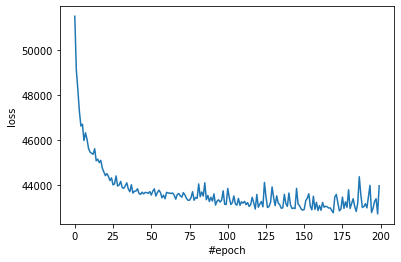

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

O (1797, 64)


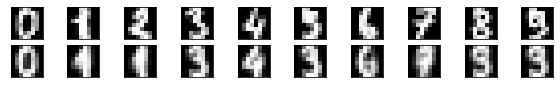

In [18]:
n_img2=10
#x3=x[:n_img2]
x2 = x_train.clone().detach()
x3 = x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = vae( x2 )

o = vae.net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

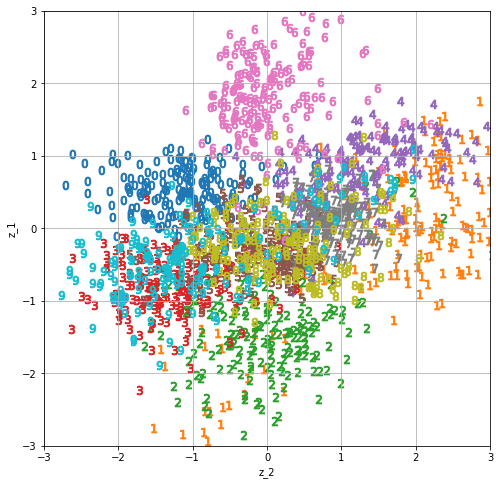

In [19]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = vae( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = vae.net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

潜在変数を変化させたときの画像を描画する

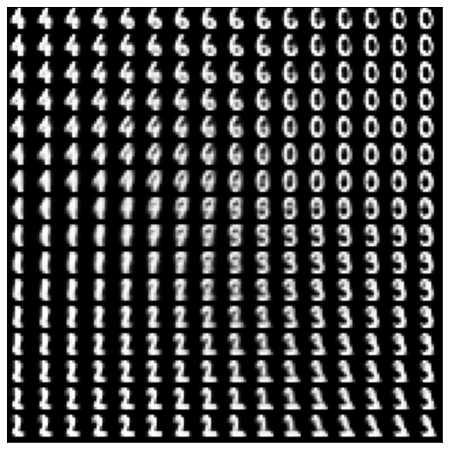

torch.Size([32, 64])


In [20]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( vae.net.fc3(zz) )
      o = torch.sigmoid( vae.net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

print(x.shape)

ミニバッチ用の学習用データファイル、学習ループのC++コードを生成する

In [21]:
CV.convert_data_file( project, folder, inp_data=dd )
CV.convert_train_code( project, folder, json_path, sol="vae", epochs=200, batch=32, lr=0.001, inp_data=dd, z="fc3" )

datafile key :  inp_data
param: inp_data  - str loop  5000  /  14375
param: inp_data  - str loop  10000  /  14375
[DATA] ./vae/vae_data.cpp
[JSON] ./vae/vae.json
epoch_num :  200
batch_size :  32
lr :  0.001
inp  shape :  1 {1797,64}
target shape :  0 
pred_num :  1797
div :  False
nadd :  53 79
pred_pos :  49 49 51
el  0 1  :  input/x IO Node [] 0 -1
el  3 1  :  VAE/Net[net]/Linear[fc1]/input.1 aten::linear [0, 1, 2] 0 -1
el  4 1  :  VAE/Net[net]/input.3 aten::relu [3] 0 -1
el  13 1  :  VAE/Net[net]/BatchNorm1d[bn1]/input.5 aten::batch_norm [4, 5, 6, 7, 8, 9, 10, 11, 12] 0 -1
el  16 1  :  VAE/Net[net]/Linear[fc2_mean]/245 aten::linear [13, 14, 15] 0 -1
el  19 1  :  VAE/Net[net]/Linear[fc2_var]/v1 aten::linear [13, 17, 18] 0 -1
el  21 1  :  VAE/Net[net]/249 aten::mul [19, 20] 0 -1
el  22 1  :  VAE/Net[net]/250 aten::exp [21] 0 -1
el  27 1  :  VAE/Net[net]/255 aten::size [25, 26] 0 -1
el  29 1  :  VAE/Net[net]/256 aten::size [25, 28] 0 -1
el  39 1  :  VAE/Net[net]/262 aten::mul [37, 38]

学習用のC++コードをコンパイル、リンクする

In [31]:
#!g++ -std=c++14 ./vae/vae.cpp ./vae/vae_param.cpp ./vae/vae_data.cpp ./vae/vae_train.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./vae/vae_train
C_SRC = './vae/vae.cpp ./vae/vae_param.cpp ./vae/vae_data.cpp ./vae/vae_train.cpp'
C_LIB = '../../../xtensor'
C_EXE = './vae/vae_train'
!echo "SRC = "$C_SRC
!echo "LIB = "$C_LIB
!echo "EXE = "$C_EXE
!g++ -std=c++14 $C_SRC -D_NOTEBOOK -D_TRAIN -I $C_LIB -lcblas -o $C_EXE

SRC = ./vae/vae.cpp ./vae/vae_param.cpp ./vae/vae_data.cpp ./vae/vae_train.cpp
LIB = ../../../xtensor
EXE = ./vae/vae_train


(注) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [33]:
!./vae/vae_train

epoch_num : 200
indata shape   : 1797,64
batch  number  : 56,32
learning ratio : 0.001
total_loss : epoch 0 - loss 61548.5
epoch 0 - loss 51670.9 ( 49610.1 , 2060.81 ) 
total_loss : epoch 1 - loss 49755.9
epoch 1 - loss 48785.1 ( 46717.4 , 2067.77 ) 
total_loss : epoch 2 - loss 48305.3
epoch 2 - loss 47748.8 ( 45903.4 , 1845.31 ) 
total_loss : epoch 3 - loss 47500.1
epoch 3 - loss 47145.5 ( 45435.1 , 1710.37 ) 
total_loss : epoch 4 - loss 46864.9
epoch 4 - loss 46375.5 ( 44024.7 , 2350.84 ) 
total_loss : epoch 5 - loss 46317.2
epoch 5 - loss 45884.3 ( 43558.7 , 2325.61 ) 
total_loss : epoch 6 - loss 45957.7
epoch 6 - loss 45909.4 ( 43528.3 , 2381.18 ) 
total_loss : epoch 7 - loss 45810.9
epoch 7 - loss 45708.3 ( 43267 , 2441.28 ) 
total_loss : epoch 8 - loss 45783
epoch 8 - loss 45764.5 ( 43300 , 2464.56 ) 
total_loss : epoch 9 - loss 45681.2
epoch 9 - loss 45610.2 ( 43111.3 , 2498.85 ) 
total_loss : epoch 10 - loss 45623.4
epoch 10 - loss 45543.4 ( 42834.2 , 2709.18 ) 
total_loss : ep

c++ からの出力ファイルの読み込み

In [34]:
# load out file
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
path = folder + '/' + project + '.pred'
f2 = open( path, 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

# load z file
path = folder + '/' + project + '.z'
f3 = open( path, 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[51670.914062, 48785.144531, 47748.757812, 47145.503906, 46375.507812, 45884.347656, 45909.433594, 45708.3125, 45764.53125, 45610.195312, 45543.390625, 45309.1875, 45369.742188, 45212.128906, 45163.8125, 45207.960938, 45031.027344, 45100.484375, 45057.152344, 44844.769531, 44894.390625, 44765.824219, 44547.664062, 44485.148438, 44670.050781, 44491.246094, 44229.183594, 44609.398438, 44173.917969, 44093.058594, 44484.917969, 44101.859375, 44181.695312, 44327.558594, 43911.394531, 43867.867188, 44046.582031, 44007.042969, 44018.90625, 43922.308594, 43744.964844, 43668.902344, 43793.640625, 43964.816406, 43740.789062, 43656.738281, 43536.632812, 43823.910156, 43726.566406, 43695.914062, 43798.554688, 43884.707031, 43627.230469, 43559.640625, 43468.144531, 43551.773438, 43745.101562, 44169.332031, 43623.765625, 43488.046875, 43393.117188, 43427.546875, 43412.078125, 43636.347656, 43591.351562, 43513.800781, 43493.851562, 43440.355469, 43399.925781, 43310.65625, 43518.375, 43328

収束状況グラフを描画する

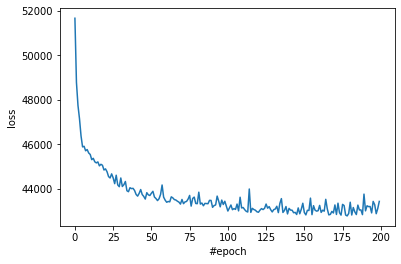

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

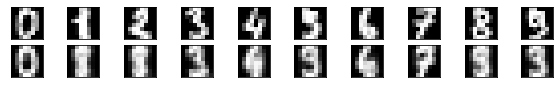

In [36]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

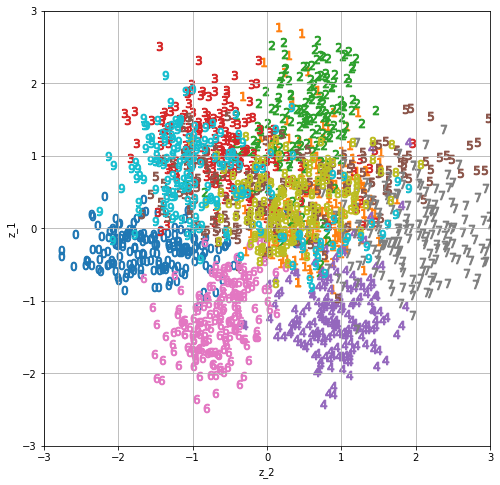

In [37]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [38]:
C_FLD = ' ./vae/'
C_SRC = './vae/vae.cpp ./vae/vae_param.cpp'
C_SRC2 = C_FLD + 'vae.cpp' + C_FLD + 'vae_param.cpp'
!echo $C_SRC
!echo $C_SRC2

./vae/vae.cpp ./vae/vae_param.cpp
./vae/vae.cpp ./vae/vae_param.cpp
